In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import math

%matplotlib inline

In [48]:
train_df = pd.read_csv('data/cs-training.csv', index_col=0)

In [49]:
#train_df = train_df.drop_duplicates()

** Rename some of the columns with dashes in the name as they are taken as minus by python **

In [50]:
train_df=train_df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30_59DaysPastDueNotWorse', 
                                  'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60_89DaysPastDueNotWorse'})

** Handle NAs. There are two features with NAs. MonthlyIncome and NumberOfDependents. We use replace
   them with 0 (mean and median could be other choices, but with 0 we get a good AUC value) **

In [51]:
train_df=train_df.fillna(value={'MonthlyIncome': 0, 
                                'NumberOfDependents': 0 })

** Some features have a large skewness. We use log transform to sanitize the values **

In [52]:
train_df['MonthlyIncome']=train_df.MonthlyIncome.apply(math.log1p)
train_df['DebtRatio']=train_df.DebtRatio.apply(math.log1p)
train_df['RevolvingUtilizationOfUnsecuredLines']=\
                            train_df.RevolvingUtilizationOfUnsecuredLines.apply(math.log1p)

** Replace the NumberOfTimes90DaysLate, NumberOfTime60_89DaysPastDueNotWorse, 
and NumberOfTime30_59DaysPastDueNotWorse with a linear combination of the values. 
The coefficients are arbitrary but obtained after some trial and error **

In [53]:
train_df['NumberOfTimesDaysLate']=101*train_df['NumberOfTimes90DaysLate'] + \
                                  51*train_df['NumberOfTime60_89DaysPastDueNotWorse'] + \
                                  23*train_df['NumberOfTime30_59DaysPastDueNotWorse']

In [54]:
train_df=train_df.drop(['NumberOfTimes90DaysLate',
                        'NumberOfTime60_89DaysPastDueNotWorse',
                        'NumberOfTime30_59DaysPastDueNotWorse'], axis=1)

** Remove any data with age == 0 **

In [55]:
train_df=train_df[train_df.age > 0]

In [56]:
y_train_df = train_df.SeriousDlqin2yrs
X_train_df = train_df.drop('SeriousDlqin2yrs', axis=1)

** The histogram for SeriousDlqin2yrs clearly shows large disparity between the binary truth classes. This
is a sign to make use of AUC metric as AUC is more robust in such cases **

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104499b00>]], dtype=object)

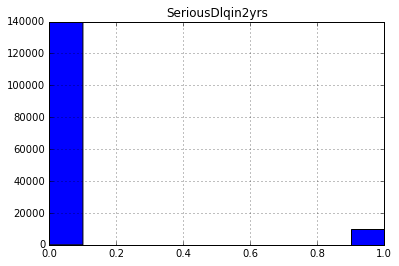

In [57]:
train_df.hist(column=['SeriousDlqin2yrs'])

In [58]:
random_state=42

In [59]:
x_train, x_rest, y_train, y_rest = train_test_split(X_train_df, y_train_df, 
                                                    test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify=y_train_df)

In [60]:
train_mat = xgb.DMatrix(x_train, y_train)

In [61]:
params = {'eta':0.1, 'seed':random_state, 'subsample':0.8,
          'colsample_bytree':0.8, 'objective': 'binary:logistic', 
          'max_depth':3, 'min_child_weight':1}

In [62]:
gbm_cv = xgb.cv(params=params, dtrain=train_mat, stratified=True,
                num_boost_round=3000, nfold=5, 
                metrics=['auc'], early_stopping_rounds=100)

In [63]:
gbm_cv.tail(5)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
140,0.864870,0.003066,0.872915,0.000637
141,0.864882,0.003060,0.872957,0.000621
142,0.864883,0.003064,0.872998,0.000615
143,0.864902,0.003071,0.873043,0.000606
144,0.864914,0.003079,0.873093,0.000601


In [64]:
final_gbm = xgb.train(params, train_mat, num_boost_round=200) 

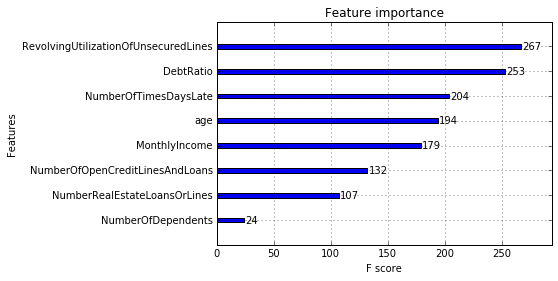

In [65]:
xgb.plot_importance(final_gbm)

In [66]:
test_mat = xgb.DMatrix(x_rest)

In [67]:
y_preds = final_gbm.predict(test_mat)

In [68]:
from sklearn import metrics

In [69]:
metrics.roc_auc_score(y_rest,y_preds)

0.87039179155166213

In [70]:
test_df = pd.read_csv('data/cs-test.csv',index_col=0)

In [71]:
test_df=test_df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30_59DaysPastDueNotWorse', 
                                'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60_89DaysPastDueNotWorse'})

In [72]:
test_df=test_df.fillna(value={'MonthlyIncome':0, 
                              'NumberOfDependents':0})

In [73]:
test_df['MonthlyIncome']=test_df.MonthlyIncome.apply(lambda x: math.log1p(x))
test_df['DebtRatio']=test_df.DebtRatio.apply(lambda x: math.log1p(x))
test_df['RevolvingUtilizationOfUnsecuredLines']=\
                                test_df.RevolvingUtilizationOfUnsecuredLines.apply(lambda x: math.log1p(x))

In [74]:
test_df['NumberOfTimesDaysLate']=101*test_df['NumberOfTimes90DaysLate'] + \
                                 51*test_df['NumberOfTime60_89DaysPastDueNotWorse'] + \
                                 23*test_df['NumberOfTime30_59DaysPastDueNotWorse']

In [75]:
test_df=test_df.drop(['NumberOfTimes90DaysLate',
                      'NumberOfTime60_89DaysPastDueNotWorse',
                      'NumberOfTime30_59DaysPastDueNotWorse'],axis=1)

In [76]:
test_df = test_df.drop('SeriousDlqin2yrs', axis=1)

In [77]:
ftest_mat = xgb.DMatrix(test_df)

In [78]:
final_preds = final_gbm.predict(ftest_mat)

In [79]:
final_preds

array([ 0.0605162 ,  0.05946226,  0.01284663, ...,  0.00455958,
        0.10588608,  0.0459673 ], dtype=float32)

In [80]:
submit_df = pd.DataFrame(data={'Id':np.arange(1,len(final_preds)+1),'Probability':final_preds})

In [81]:
submit_df.to_csv('data/submission.csv', index=False)